In [9]:
import numpy as np
import pandas as pd
import datetime as dt
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from __future__ import division

%matplotlib inline

# Get the data

In [2]:
filename = 'Algorithms_Data.csv'
data = pd.read_csv(filename)
data = data[-15000:]  # Training on more than this doesn't seem to improve results, but takes longer
targets = data['Win']
data = data[['fran_elo', 'opp_elo', 'RollAvg_A_5_pts', 'RollAvg_B_5_pts', 'RollAvg_A_5_opp_pts', 'RollAvg_B_5_opp_pts', 'Days_Since_Last']]

In [3]:
pd.concat([data.head(), targets.head()], axis=1)

,fran_elo,opp_elo,RollAvg_A_5_pts,RollAvg_B_5_pts,RollAvg_A_5_opp_pts,RollAvg_B_5_opp_pts,Days_Since_Last,Win
32530,1489.768214,1684.042297,91.8,95.2,96.2,86.8,1.0,False
32531,1569.508971,1558.067109,83.8,93.2,77.4,84.4,1.0,False
32532,1687.615767,1528.192875,107.2,98.2,94.2,92.2,1.0,False
32533,1509.910406,1448.525491,101.2,100.0,106.8,97.6,1.0,False
32534,1456.563819,1571.171564,97.4,93.6,91.2,83.6,3.0,False


The above table is a sample of the data we will be using in order to predict whether the home team will win an NBA basketball game. Each row represents one match up between two basketball teams. Team A is the away team, team B is the home team.  Note a value of False in the Win column implies that team B (the home team) won.

The ELO rating system is a method for calculating the relative skill levels of players in two-player games such as chess. We have adapted this system in order to measure skill levels of different NBA teams based on their recent performance.  We computed the ELO ratings for each team over the history of our dataset, and we use this as a feature.

fran_elo: The ELO ranking for the away team (A) at the time this game was played.

opp_elo: The ELO ranking for the home team (B) at the time this game was played.

RollAvg_A_5_pts: For the away team, the average points this specific team has scored in their last 5 games.

RollAvg_B_5_pts: For the home team, the average points this specific team has scored in their last 5 games.

RollAvg_A_5_opp_pts: For the home team, the average points this specific team has allowed in their last 5 games.

RollAvg_B_5_opp_pts: For the away team, the average points this specific team has allowed in their last 5 games.

Days_Since_Last: Number of days since the away team last played a game.

For more information on the ELO scores, see our Machine Learning page.

In [5]:
def runAlgorithm(model, trials=10,):
    """ Run a given machine learning algorithm on globally defined data.
       Splits data randomly into test and training sets.
       Returns the average time and accuracy.
   
   :param model: A sklearn model initialized with parameters.
   :param trials: Number of trials to run.  Defaults to 10.
   """
   
    t1 = []
    t2 = []
    preds =[]
    for t in range(trials):
        X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
        t1.append(time.time())

        model.fit(X_train, y_train)
        preds.append(np.mean((model.predict(X_test)>.5) == y_test))
        t2.append(time.time())

    return (np.mean(preds),np.mean(np.array(t2)-np.array(t1))),preds


def plotDist(results,bins=25):
    plt.hist(results, bins=bins)
    plt.show()

# Application of ML algorithms

## Baseline
Guess that the home team wins every game.  If a method doesn't do better than this, it isn't learning much.

In [7]:
t1 = []
t2 = []
preds = []
for t in range(100):
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
    t1.append(time.time())

    preds.append((np.zeros(len(y_test)) == y_test).mean())
    t2.append(time.time())

baseline_ = (np.mean(preds), np.mean(np.array(t2)-np.array(t1))), preds
print 'Accuracy: {}\nTime: {}'.format(*baseline_[0])

Accuracy: 0.598743333333
Time: 0.000361242294312


## SVM

In [11]:
from sklearn import svm
from sklearn import preprocessing

accuracy = []
times = []
for i in xrange(50):
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
    X = preprocessing.scale(X_train)
    s = time.time()
    SVM_model = svm.SVC(C=10**-5, kernel='poly', coef0=0, gamma=10**-2).fit(X, y_train)
    preds = SVM_model.predict(X_test)
    prob = np.sum(preds == y_test)/len(y_test)
    times.append(time.time() - s)
    accuracy.append(prob)

svm_r = (np.mean(accuracy), np.mean(times)), accuracy
print 'Accuracy: {}\nTime: {}'.format(*svm_r[0])


Accuracy: 0.656546666667
Time: 3.70445244312


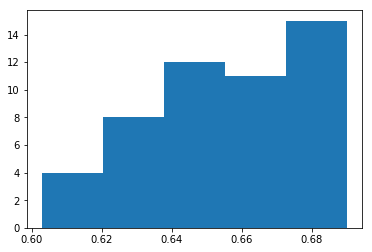

In [12]:
plotDist(svm_r[1],5)

## Logistic Regression

Accuracy: 0.759062333333
Time: 0.0362885010242


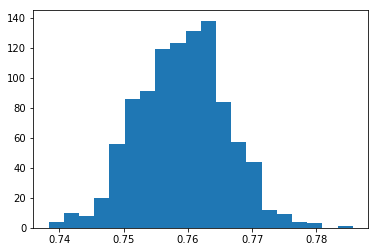

In [10]:
from sklearn import linear_model as lm

lam = 10**2

lr_model = lm.LogisticRegression(C=np.abs(1/lam))
log_reg = runAlgorithm(lr_model, trials=1000)
print 'Accuracy: {}\nTime: {}'.format(*log_reg[0])
plotDist(log_reg[1],20)

## Ridge Regression 

Accuracy: 0.758925333333
Time: 0.00202781486511


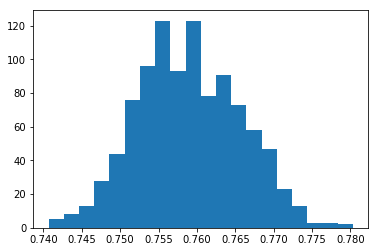

In [13]:
from sklearn.linear_model import Ridge as ri

skRidge = ri()
rid_reg = runAlgorithm(skRidge,trials = 1000)
print 'Accuracy: {}\nTime: {}'.format(*rid_reg[0])
plotDist(rid_reg[1], 20)

## Linear Discriminant Analysis

Accuracy: 0.758360666667
Time: 0.00576182866096


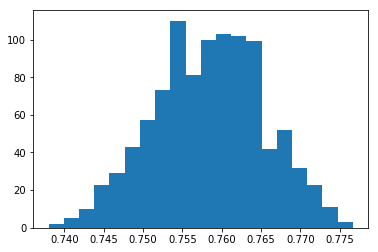

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis(solver='svd')
lda_ = runAlgorithm(lda_model,1000)
print 'Accuracy: {}\nTime: {}'.format(*lda_[0])
plotDist(lda_[1],20)

## Quadratic Discriminant Analysis

Accuracy: 0.755959
Time: 0.00454934024811


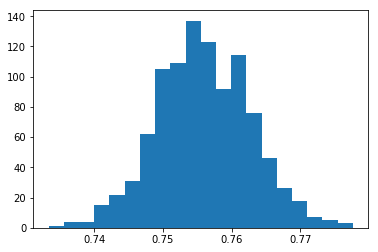

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis()
qda_= runAlgorithm(qda_model, 1000)
print 'Accuracy: {}\nTime: {}'.format(*qda_[0])
plotDist(qda_[1],20)

## Gradient Boost 

Accuracy: 0.74067
Time: 0.702680158615


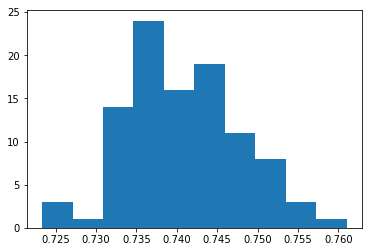

In [16]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

#start = time.time()
gbc = GBC(max_leaf_nodes=500, min_weight_fraction_leaf=0.001, min_samples_split=100, learning_rate=.4, max_features="auto")
grad = runAlgorithm(gbc, trials=100)
print 'Accuracy: {}\nTime: {}'.format(*grad[0])
plotDist(grad[1],10)

## MLP

Accuracy: 0.742211111111
Time: 5.33891376654


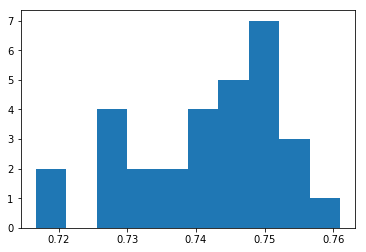

In [17]:
from sklearn.neural_network import MLPClassifier as mlp

start = time.time()
gbm = mlp(solver="lbfgs", activation='tanh', tol=1e-4, alpha=1e-5)
mlp_r = runAlgorithm(gbm, trials=30)
print 'Accuracy: {}\nTime: {}'.format(*mlp_r[0])
plotDist(mlp_r[1],10)

## Random Forests

Accuracy: 0.742566666667
Time: 1.72483811378


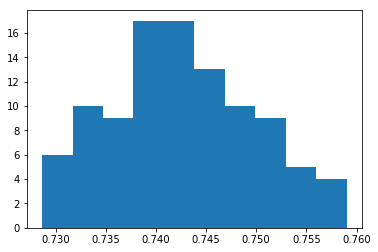

In [18]:
from sklearn.ensemble import RandomForestClassifier as RFC

rfc = RFC(min_samples_split=3, n_estimators =100)
forest = runAlgorithm(rfc, trials=100)
print 'Accuracy: {}\nTime: {}'.format(*forest[0])
plotDist(forest[1],10)

## Decision Tree

Accuracy: 0.663328666667
Time: 0.111246701241


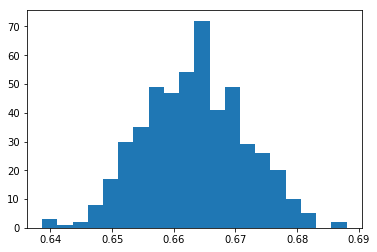

In [19]:
from sklearn.tree import DecisionTreeClassifier as DTC

dtc = DTC(criterion='entropy')
tree = runAlgorithm(dtc, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*tree[0])
plotDist(tree[1],20)

## XGBoost

/home/sterling/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy: 0.748094
Time: 0.0967609968185


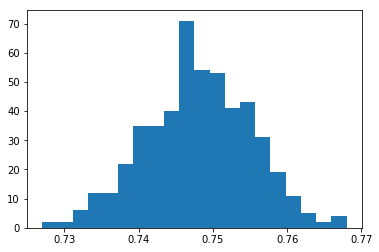

In [20]:
import xgboost as xgb
accuracy = []
times = []
for i in xrange(500):
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
    start = time.time()
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)

    param = {'objective':'multi:softmax', 'num_class':5,'normalize_type':'forest','rate_drop':1, 'lambda':50, 'alpha':10}
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest) > .5
    accuracy.append((preds == y_test).mean())
    times.append(time.time() -start)
    #print preds

xgb_r = (np.mean(accuracy), np.mean(times)),accuracy
print 'Accuracy: {}\nTime: {}'.format(*xgb_r[0])
plotDist(xgb_r[1], 20)

# Model Comparison

In [21]:
comps = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Time'])
comps['Algorithm'] = ['Baseline', 'SVM', 'Logistic Regression', 'Ridge Regression', 
                      'Gradient Boost', 'XGBoost',
                      'MLP', 'Decision Tree', 'Random Forest', 'LDA', 'QDA']

results = [baseline_, svm_r, log_reg, rid_reg, grad, xgb_r, mlp_r, tree, forest, lda_, qda_]
comps['Accuracy'] = [m[0][0] for m in results]
comps['Time'] = [m[0][1] for m in results]

comps.sort_values('Accuracy', ascending=False).reset_index(drop=True)

,Algorithm,Accuracy,Time
0,Logistic Regression,0.759062,0.036289
1,Ridge Regression,0.758925,0.002028
2,LDA,0.758361,0.005762
3,QDA,0.755959,0.004549
4,XGBoost,0.748094,0.096761
5,Random Forest,0.742567,1.724838
6,MLP,0.742211,5.338914
7,Gradient Boost,0.740670,0.702680
8,Decision Tree,0.663329,0.111247
9,SVM,0.656547,3.704452


In [22]:
comps.sort_values('Time').reset_index(drop=True)

,Algorithm,Accuracy,Time
0,Baseline,0.598743,0.000361
1,Ridge Regression,0.758925,0.002028
2,QDA,0.755959,0.004549
3,LDA,0.758361,0.005762
4,Logistic Regression,0.759062,0.036289
5,XGBoost,0.748094,0.096761
6,Decision Tree,0.663329,0.111247
7,Gradient Boost,0.740670,0.702680
8,Random Forest,0.742567,1.724838
9,SVM,0.656547,3.704452


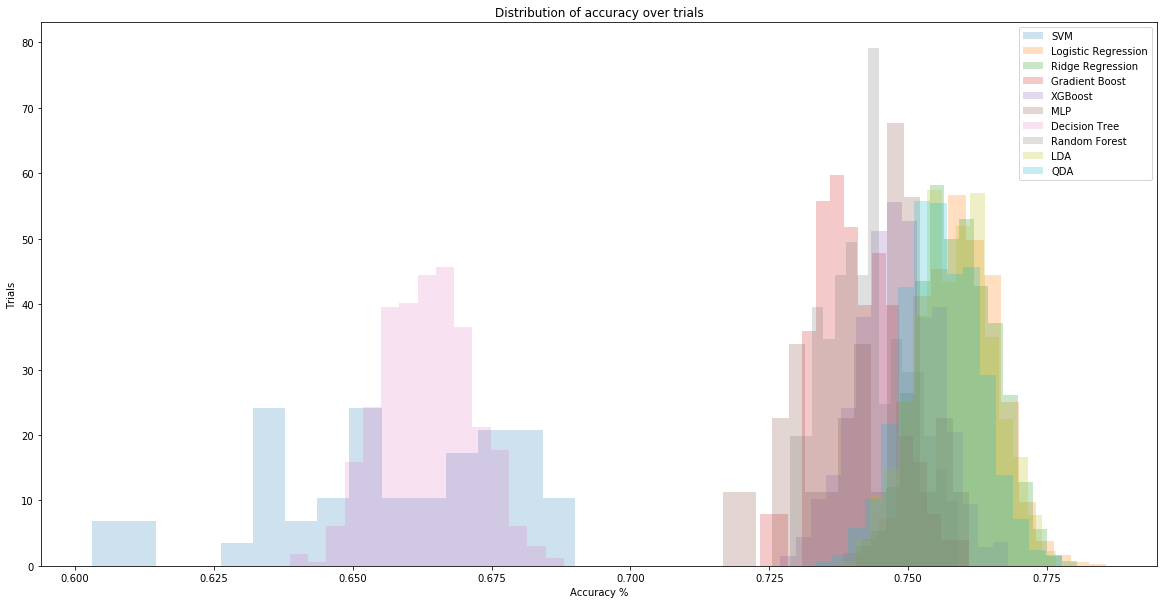

In [52]:
plt.figure(figsize=(20,10))
i = 1
for model in results[1:]:
    lab = comps['Algorithm'][i]
    trans = comps['Accuracy'][i]
    i+=1
    plt.hist(model[1],alpha=trans/3.,bins=15,label=lab,normed=True)
    
plt.title("Distribution of accuracy over trials")
plt.xlabel("Accuracy %")
plt.ylabel("Trials")

plt.legend()
plt.show()

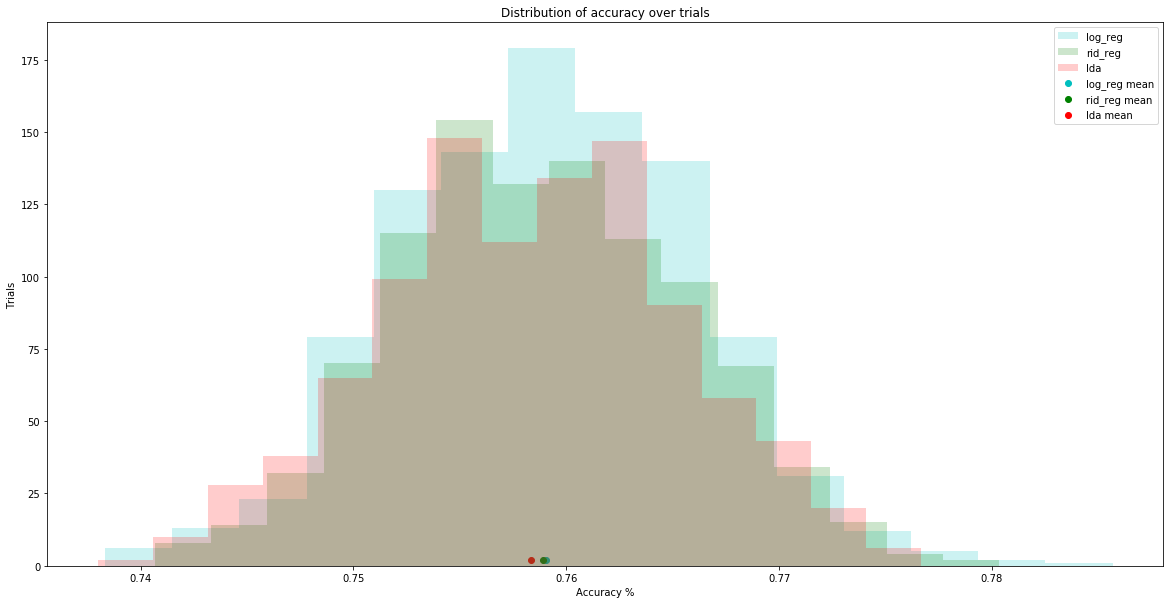

In [53]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(log_reg[1],color='c',alpha=0.2,bins=15, label='log_reg')
ax.hist(rid_reg[1],color='g',alpha=0.2,bins=15, label='rid_reg')
ax.hist(lda_[1],color='r',alpha=0.2,bins=15, label='lda')

ax.scatter(log_reg[0][0], 2, color='c', label="log_reg mean")
ax.scatter(rid_reg[0][0], 2, color='g', label='rid_reg mean')
ax.scatter(lda_[0][0], 2, color='r', label='lda mean')
plt.legend()
plt.title("Distribution of accuracy over trials")
plt.xlabel("Accuracy %")
plt.ylabel("Trials")

plt.show()

## Evaluate accuracy and effectiveness of the methods you used and compare the relative strengths and weaknesses of each method for this particular project.  

The methods that we focused on were regression based methods, tree based methods, neural nets, and SVMs. 

### Regression based
Methods used: Logistic Regression, Ridge Regression

Both methods worked extremely well, with accuracies around 76% and running in only ~.03 seconds.  Note that logistic regression is really just a classifier, meaning the output is 1 or 0.  However, ridge regression outputs a continuous variable. Since a regression algorithm returns a continuous output, we set a threshold value of .5.  In other words, if the model returns a number greater than .5, we classified this as 1 or True.

### Tree based
Methods used: Decision Tree, Random Forest, Gradient Boost, XGBoost

Random Forests ran about as accurately as some of our better performers at 74%, but is a much slower method running in about a second and a half.

As expected, Decision Trees ran less accurately than Random Forests at 67% but runs much faster at ~.1 seconds. Decision Trees are one of the fasted methods we tested.

XGBoost was among the best of the tree methods, both fast and respectably accurate.  However, we could not quite get it to surpass the regression methods in accuracy, and those take only half the time.

Gradient Boost performed just under XGBoost both in time and accuracy.


### Gaussian Discriminant Analysis
Methods used: Linear Discriminant Analysis, Quadratic Discriminant Analysis

Despite their simplicity and the lack of parameters to tune, these two methods both achieve accuracy above 75% and run quickly. They are not quite as accurate as the regression methods, but they are about an order of magnitude faster. The fact that this works so well suggests that the wins and losses are somewhat linearly separable.


### Neural nets
Methods used: MLP

Our Multi Layer Perception (MLP) was as accurate as many of our top performers at ~75%, but was by far our slowest algorithm taking nearly 7.5 seconds to run. As such even though it is accurate, we would not choose to continue working with it because it is so much slower than other algorithms that are equally accurate.

### SVM
Our Support Vector Machine ran the worst accuracy out of any of our other methods at 65%. It also was our second slowest methods running at nearly 3 seconds. Because it was outperformed by almost all of our other tests in both categories, we will not continue working with this method.

# Algorithms we chose not to use

### Nearest neighbor

Due to the fact that we are not performing any kind of cluster analysis, we have decided the NN-classifying and NN-regression algorithms are not useful. 

### Mixture models with latent variables (train with EM)

Because there is not an unknown distribution in our dataset, mixture models along with EM will not work with our data set.


### Kalman Filters

Our data is not a true time series because we are not interested in how teams' overall performances changes over time. Games are decided strictly by winners and losers, so there is not any measurable error or noise. Because of this we have determined that it will not be useful in our methods. 

### AR, MA, ARMA, ARIMA time series models

Because these models are trying to describe certain time-varying processes of a time series, they will not be helpful in trying to predict wins and losses of specific games. 

# Summary

Basketball game outcomes are very unreliable.  Even a team that has performed well for the last few games can suddenly and inexplicably lose to a team that has been performing poorly; and this happens not infrequently.  Due to these vagaries, we feel that 75% accuracy is quite reasonable for this stage of our project.  We hope to improve on this over the next month by including more features in our data, namely team statistics: free throws, shots attempted, steals, percentages, and so forth.

# New Methods

## SVR
Epsilon-Support Vector Regression.  Support vector regression is very similar to support vector classification.  However, we are now assuming our output is continuous.  SVM constructs a hyperplane in a high dimensional space.  Just like support vector classification, support vector regression only depends on a subset of the data. Our testing showed that SVR is not a great algorithm for our methods. It was much less effective than our best algorithms at only 59% and is also considerably slower at over 4 seconds to compute.

Accuracy: 0.600966666667
Time: 5.5179433465


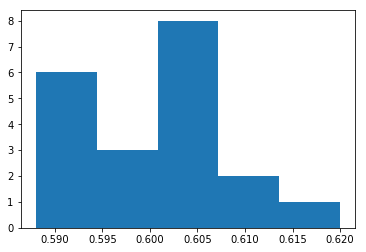

In [25]:
from sklearn import svm
from sklearn import preprocessing


accuracy = []
times = []
for i in xrange(20):
    X = preprocessing.scale(data)
    X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=.2)
    
    s = time.time()
    SVR_model = svm.SVR(C=10**-7, epsilon=.1, kernel='poly', coef0=-2, gamma=10**-4).fit(X_train, y_train)
    preds = SVR_model.predict(X_test) <= 0
    prob = 1.*np.sum(preds == y_test)/len(y_test)
    times.append(time.time() - s)
    accuracy.append(prob)

svm_r = ((np.mean(accuracy), np.mean(times)),accuracy)
print 'Accuracy: {}\nTime: {}'.format(*svm_r[0])
plotDist(svm_r[1],5)

## Orthogonal Matching Pursuit (OMP)
Matching Pursuit is a signal processing algorithm that recovers a close approximation to a noisy signal using a redundant dictionary of basis functions (meaning there are orders of magnitude more candidates in the dictionary than we actually use in the linear combination).  The idea is to minimize the difference between the signal and the approximation, but there are far too many linear combinations to check.  So the algorithm first chooses the function that gives the largest product with the signal, and then on each iteration chooses the function that matches with the signal minus the results of the former iterations.

Orthogonal Matching Pursuit extends this idea by updating the coefficients on each function after computing the orthogonal projection of the signal onto each of the functions chosen so far.

Our testing with this algorithm showed that OMP turned out to be one of our best performing methods, in accuracy and in speed.

Accuracy: 0.758670666667
Time: 0.00286334323883


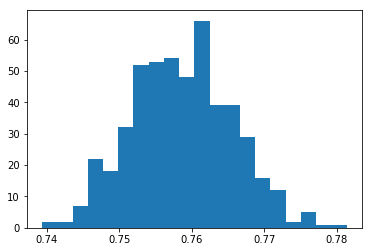

In [26]:
from sklearn import linear_model as lm

model = lm.OrthogonalMatchingPursuit(n_nonzero_coefs=7, precompute=True)
omp = runAlgorithm(model, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*omp[0])
plotDist(omp[1],20)

## Extra Trees Classifier

An extra trees classifier, otherwise known as an “Extremely randomized trees” classifier, is a variant of a random forest. Unlike a random forest, at each step the entire sample is used and decision boundaries are picked at random, rather than the best one. In real world cases, performance is comparable to an ordinary random forest, sometimes better.

An extra tree classifier works by completely randomizing attribute and cutoff when splitting the tree. This means that the structure of the tree is independent of the data. By using a forest of these trees, we can get good accuracy. The randomness improves computational efficiency. The randomness can be adjusted using parameters, though the max randomness performs very well.

More information is [here](https://pdfs.semanticscholar.org/336a/165c17c9c56160d332b9f4a2b403fccbdbfb.pdf).

Accuracy: 0.744383333333
Time: 1.04486467838


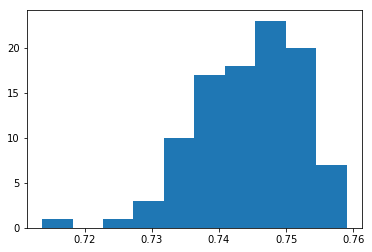

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
extraforest = ExtraTreesClassifier(n_estimators=100, oob_score=True, bootstrap=True)

xtrees = runAlgorithm(extraforest,trials=100)
print 'Accuracy: {}\nTime: {}'.format(*xtrees[0])
plotDist(xtrees[1],10)

## Bayesian Ridge Regression

Estimates a probabilistic model of the regression problem. The prior for the parameter w is given by a spherical Gaussian. The priors over alpha and lambda are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The parameters are estimated by maximizing the marginal log likelihood.

The Bayesian Ridge Regression is very similar to the ridge regression, but the parameters are estimated using Bayesian methods in which the hyperparameters, $\alpha$, $w$, and $\lambda$ are estimated jointly in the fitting of the model. This optimization of hyperparameters in mathematically equivalent to the L2 penalized maximum likelihood estimation. The main advantage the Bayesian method has over regular least squares is its robustness to ill-posed problems and outliers in the data.

More information can be found [here](http://www.onthelambda.com/2016/10/30/the-bayesian-approach-to-ridge-regression/).

Accuracy: 0.758848
Time: 0.00354864549637


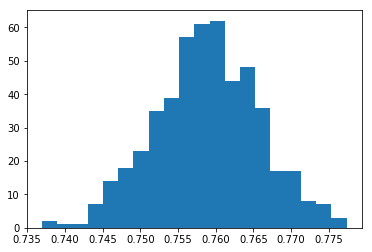

In [28]:
from sklearn import linear_model as lm

model = lm.BayesianRidge()
bayes_ridge = runAlgorithm(model, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*bayes_ridge[0])
plotDist(bayes_ridge[1],20)

## Voting Classifier

A Voting Classifier is used to employ multiple individual classifiers and combine their predictions, which could achieve better performance than a single classifier. We are going to use Linear Regression, Linear and Quadratic Discriminate Analysis (our top three performing algorithms) to run this classifier. Our results show that it is sometimes slightly better on the order of hundredths and thousandths than each individual algorithm on its own, and thus not significantly more effective.  This classifier will take much longer to learn because it has to train all 3 classifiers.  If the voting is set to 'hard' then the predicted class labels are chosen based on majority rule voting.  If 'soft' the label is chosen based on the argmax of the sums of the predicted probabilities.

Accuracy: 0.758365333333
Time: 0.0505385766029


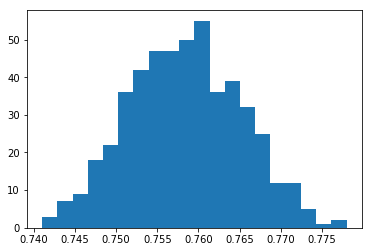

In [29]:
from sklearn.ensemble import VotingClassifier

vote_model = VotingClassifier(estimators=[('LR', lr_model),('LDA',lda_model),('QDA',qda_model)], voting='soft')
voting = runAlgorithm(vote_model, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*voting[0])
plotDist(voting[1],20)

In [55]:
xcomps = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Time'])
xcomps['Algorithm'] = ['Baseline', 'SVM', 'Logistic Regression', 'Ridge Regression', 
                      'Gradient Boost', 'XGBoost',
                      'MLP', 'Decision Tree', 'Random Forest', 'LDA', 'QDA',
                      'SVR', 'OMP', 'ExtremeTrees', 'Bayes Ridge', 'Voting']

xresults = [baseline_, svm_r, log_reg, rid_reg, grad, xgb_r, mlp_r, tree, forest, lda_, qda_,
           svm_r, omp, xtrees, bayes_ridge, voting]

xcomps['Accuracy'] = [m[0][0] for m in xresults]
xcomps['Time'] = [m[0][1] for m in xresults]

xcomps.sort_values('Accuracy', ascending=False).reset_index(drop=True)

,Algorithm,Accuracy,Time
0,Logistic Regression,0.759062,0.036289
1,Ridge Regression,0.758925,0.002028
2,Bayes Ridge,0.758848,0.003549
3,OMP,0.758671,0.002863
4,Voting,0.758365,0.050539
5,LDA,0.758361,0.005762
6,QDA,0.755959,0.004549
7,XGBoost,0.748094,0.096761
8,ExtremeTrees,0.744383,1.044865
9,Random Forest,0.742567,1.724838


In [56]:
xcomps.sort_values('Time').reset_index(drop=True)

,Algorithm,Accuracy,Time
0,Baseline,0.598743,0.000361
1,Ridge Regression,0.758925,0.002028
2,OMP,0.758671,0.002863
3,Bayes Ridge,0.758848,0.003549
4,QDA,0.755959,0.004549
5,LDA,0.758361,0.005762
6,Logistic Regression,0.759062,0.036289
7,Voting,0.758365,0.050539
8,XGBoost,0.748094,0.096761
9,Decision Tree,0.663329,0.111247


## Summary of New Methods 

In our research of new methods we decided to implement the Support Vector Regression, Orthogonal Matching Pursuit, Extra Trees Classifier, Bayesian Ridge Regression, and the Voting Classifier. Some of these, namely Voting Classifier, Orthogonal Matching Pursuit, and Bayesian Ridge Regression, performed as well or slightly better than our previous best algorithms. The others were significantly worse either in speed or accuracy, discouraging their further use in our project. Our findings from these methods reflect what we have previously seen: regression methods and tree methods seem to be best suited for predictions with our data. Previously we obtained our best results from Logistic and Ridge Regression along with Random Forests and XGBoost. Surprisingly, the sparse approximation algorithm Orthogonal Matching Pursuit also performed well with our data in speed and accuracy, the only non regression or tree-based method to do so. Because of this, we plan to search for more algorithms similar to OMP to include in our future reasearch. 